In [1]:
import math
from os import listdir
from itertools import product
from collections import Counter
import pickle 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.stats import ks_2samp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolDescriptors, MolFromSmiles, MolToSmiles, Draw, MolFromMolFile
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.rdmolfiles import MolFromPDBBlock, MolFromPDBFile
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

import py3Dmol
import mols2grid

from rdkit.Chem.SaltRemover import SaltRemover
remover = SaltRemover()

import frag_funcs
import importlib
importlib.reload(frag_funcs)

from ipywidgets import interact


# Data Reading

In [2]:
def clean_smi(smi):
    read_mol = MolFromSmiles(smi)
    read_mol = remover.StripMol(read_mol)
    smi = MolToSmiles(read_mol)
    return smi

lib_smi = [clean_smi(smi) for smi in pd.read_csv('/home/wjm41/ml_physics/frag-pcore-screen/data/DSI_lib.csv')['Smile']]

data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/DPP11'

df_sites = pd.read_csv(data_dir + '/hits_ids.csv')

print('Length of df_sites :{}'.format(len(df_sites)))

# 20/07/2021
# Active site Upper,0
# Active site Lower,1
# AllostericY675,2

sites = [2]

df_sites = df_sites[df_sites['site_number'].isin(sites)]

print('Length of new df_sites :{}'.format(len(df_sites)))

frags = []
smiles_list = []
ids = []
for i,row in tqdm(df_sites.iterrows(), total=len(df_sites)):
    try:
        crystal_id = row['crystal_id'].split(':')[0]
        
        smiles_path =  data_dir + '/aligned/'+crystal_id+'/'+crystal_id+'_smiles.txt'
        f = open(smiles_path, "r")
        smiles = f.read()
        smiles = MolToSmiles(MolFromSmiles(smiles))
        
#         pdbname = data_dir + '/aligned/'+crystal_id+'/'+crystal_id+'.pdb'
#         file = open(pdbname, 'r')
#         data = file.read().splitlines()
#         ligand = [line for line in data if 'LIG A' in line and 'HETATM' in line]
#         pdbblock = '\n'.join(ligand)
#         print(pdbblock)
#         mol = MolFromPDBBlock(pdbblock)
#         mol = MolFromPDBFile(pdbname, flavor=1, proximityBonding=True)
#         print(mol)
#         read_mol = MolFromSmiles(smiles)
#         mol = AllChem.AssignBondOrdersFromTemplate(read_mol, mol)    
        
        mol_path = data_dir + '/aligned/'+crystal_id+'/'+crystal_id+'.mol'
        mol = MolFromMolFile(mol_path) 
        conf = mol.GetConformer()

        ligand_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            ligand_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]])
            
        smiles_list.append(smiles)
        frags.append(ligand_data)
        ids.append(crystal_id.split('-')[1].split('_')[0])  

    except Exception as ex:
        print("Couldn't generate conformers for {}".format(smiles))
        print(ex)

print('Including extra PDBs...')
extra_pdbs = [file for file in listdir(data_dir) if '.pdb' in file]

for file in extra_pdbs:
    try:
        crystal_id = file.split('-')[1].split('.')[0]
        
        file = open(data_dir+'/'+file, 'r')
        data = file.read().splitlines()
        ligands = [line for line in data if 'LIG' in line]
        
        ligand_ids = sorted(list(set(line.split('LIG')[1][1:6] for line in ligands)))

        for ligand_id in ligand_ids:
            ligand = [line for line in ligands if ligand_id in line]
            pdbblock = '\n'.join(ligand)
    #         print(pdbblock)
            mol = MolFromPDBBlock(pdbblock, flavor=1)
    #         print(mol)
    #         smiles = MolToSmiles(mol)
            for smi in lib_smi:
                try:

                    read_mol = MolFromSmiles(smi)
                    read_mol = remover.StripMol(read_mol)

                    new_mol = AllChem.AssignBondOrdersFromTemplate(read_mol, mol)
                    conf = new_mol.GetConformer()

                    ligand_data = [new_mol]
                    for j,atom in enumerate(new_mol.GetAtoms()):
                        ligand_data.append([atom.GetSymbol(),
                                            conf.GetPositions()[j]])

                    frags.append(ligand_data)
                    ids.append(crystal_id)
                    smiles_list.append(smi)
                    break
                except ValueError as ex:
    #                 print(ex)
                    continue
    except Exception as ex:
        print("Couldn't generate conformers for {}".format(crystal_id))
#         print(ex)

print('Total number of extracted fragments: {}'.format(len(frags)))

 14%|█▎        | 3/22 [00:00<00:00, 26.41it/s]

Length of df_sites :27
Length of new df_sites :22


100%|██████████| 22/22 [00:00<00:00, 28.44it/s]


Including extra PDBs...
Total number of extracted fragments: 33


# Sanity check plotting

In [15]:
mols = []

for frag in frags:
    tmp = frag[0]
    tmp = Chem.RemoveHs(tmp)
    AllChem.Compute2DCoords(tmp)
    mols.append(tmp)

print('Number of noncovalent binding frags: {}'.format(len(mols)))

mol_df = pd.DataFrame({"mol": mols,
                   "name": ids})
mols2grid.display(mol_df, mol_col='mol', subset=['img', 'name'], tooltip=['name'], selection=True, n_cols=6, n_rows=6)

Number of noncovalent binding frags: 33


In [3]:
view = py3Dmol.view()

# some fragments don't look like they're in the correct site (indices in bad_frags)
# dup_frags contains the same fragment three times

bad_frags = [32, 30, 28, 25, 23, 22] # fixed!
dup_frags = [6, 8, 31]

# recount weights

smiles_new = [smi for i,smi in enumerate(smiles_list) if i not in bad_frags]
counts = Counter(smiles_new)
# print(counts)
weights = [1/counts[smi] for smi in smiles_new]
print(weights)
print(len(weights))

file = open(data_dir+'/aligned/PGN_RS02895PGA-x0032_0A/PGN_RS02895PGA-x0032_0A_apo-desolv.pdb','r')
protein = file.read()
# view.addModel(protein, 'pdb')

for i,mol in enumerate(frags):
    if i not in bad_frags and i in dup_frags:  
    # if i not in bad_frags: 
#     if i in bad_frags:
        mb = Chem.MolToMolBlock(Chem.RemoveHs(mol[0]), confId=-1)
        view.addModel(mb, 'sdf')
view.setStyle({'stick': {}})
# view.setStyle({'model': 0},{'cartoon':{}})
view.setBackgroundColor('0xeeeeee')
view.zoomTo()

frags_save = [frag for i,frag in enumerate(frags) if i not in bad_frags]
pickle.dump(frags_save, open(data_dir + '/frags_dpp11.pickle', 'wb'))
pickle.dump(weights, open(data_dir + '/weights_dpp11.pickle', 'wb'))

view

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333]
27


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3D Pharmacophore Plotting

In [15]:
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

colors = {'Donor': 'O','Acceptor': 'N','Aromatic':'Cl'}

frag_df = frag_funcs.return_pcore_dataframe(frags_save, interesting_pcores)

frag_df = frag_df[['pcore','coord_x','coord_y','coord_z']]
frag_df['pcore'] = [colors[x] for x in frag_df['pcore']]
frag_df['coord_x'] = frag_df['coord_x'].astype(str)
frag_df['coord_y'] = frag_df['coord_y'].astype(str)
frag_df['coord_z'] = frag_df['coord_z'].astype(str)

# print(frag_df.head())
def plot_3d(r, protein = False):
    view = py3Dmol.view()   
    if protein:
        file = open(data_dir+'/aligned/PGN_RS02895PGA-x0032_0A/PGN_RS02895PGA-x0032_0A_apo-desolv.pdb','r')
        mpro = file.read()
        view.addModel(mpro, 'pdb')
        view.setStyle({'model': -1},{'cartoon':{}})

    frag_pcores=str(len(frag_df))+'\n\n'
    vol_data = []
    for i, row in frag_df.iterrows():
        vol_data.append(row['pcore']+' '+row['coord_x']+' '+row['coord_y']+' '+row['coord_z'])
        frag_pcores = frag_pcores + row['pcore']+' '+row['coord_x']+' '+row['coord_y']+' '+row['coord_z']+'\n'
    view.addModel(frag_pcores, 'xyz')
    view.setStyle({'model': -1},{'sphere': {'radius':r, 'opacity':0.75}})
    view.setBackgroundColor('0xffffff')
#     view.addSurface(py3Dmol.MS, {'opacity': 1.0})    
    view.zoomTo()
    view.show()
    return None

interact(plot_3d, r=(0.1,1.0,0.1), protein=False); # (min, max, step)


100%|██████████| 27/27 [00:00<00:00, 64.25it/s]


interactive(children=(FloatSlider(value=0.5, description='r', max=1.0, min=0.1), Checkbox(value=False, descrip…

In [82]:
import importlib
importlib.reload(frag_funcs)

<module 'frag_funcs' from '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/frag_funcs.py'>

### Generate 2-body distributions 

In [4]:
n_rand = 10

frag_pair_distance_dict = {} 
frag_weight_dict = {} 
rand_pair_dicts = [{} for i in range(n_rand)]  
rand_weight_dicts = [{} for i in range(n_rand)]  

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

fragpcore_df = frag_funcs.return_pcore_dataframe(frags_save, interesting_pcores, weights = weights)
rand_dfs = [frag_funcs.return_random_dataframe(frags_save, interesting_pcores) for i in range(n_rand)]

for pcore_pair in tqdm(product(interesting_pcores,repeat=2)):
    core_a,core_b = pcore_pair
    combo = core_a+'-'+core_b
    
    twobody_hists, twobody_weights = frag_funcs.get_pair_distances(fragpcore_df, core_a, core_b, frag=True)
    frag_pair_distance_dict[combo] = np.hstack(twobody_hists)
    frag_weight_dict[combo] = np.hstack(twobody_weights)
    
    for i,rand_df in enumerate(rand_dfs):
        twobody_hists, twobody_weights = frag_funcs.get_pair_distances(rand_df, core_a, core_b, frag=True)
        rand_pair_dicts[i][combo] = np.hstack(twobody_hists)
        rand_weight_dicts[i][combo] = np.hstack(twobody_weights)

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/pickles'
pickle.dump(frag_pair_distance_dict, open(
    pickle_dir + '/frag_pair_distance_dict_dpp11.pickle', 'wb'))
pickle.dump(rand_pair_dicts, open(pickle_dir + '/rand_pair_dicts_dpp11.pickle', 'wb'))

pickle.dump(frag_weight_dict, open(pickle_dir + '/frag_weight_dict_dpp11.pickle', 'wb'))
pickle.dump(rand_weight_dicts, open(pickle_dir + '/rand_weight_dicts_dpp11.pickle', 'wb'))


100%|██████████| 27/27 [00:00<00:00, 91.66it/s]
/home/wjm41/ml_physics/frag-pcore-screen/notebooks/frag_funcs.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pcore_df.iloc[counter:partition_indices[i]+counter]['pcore'] = pcore
9it [00:19,  2.12s/it]


In [12]:
combo_list = []

kde_dict = {}
rand_kde_dicts = [{} for i in range(n_rand)]

pairs = ['Donor-Aromatic',
         'Aromatic-Acceptor',
         'Aromatic-Aromatic',
         'Donor-Donor',
         'Donor-Acceptor',
         'Acceptor-Acceptor']

kde_dict_opt = {}
for combo in tqdm(pairs):
    kde_dict_opt[combo] = frag_funcs.fit_pair_kde(frag_pair_distance_dict[combo], weight=frag_weight_dict[combo], top=1, bottom=-1, n=50)
    for i in range(n_rand):
        rand_kde_dicts[i][combo] = frag_funcs.fit_pair_kde(rand_pair_dicts[i][combo], weight=rand_weight_dicts[i][combo], top=1, bottom=-1, n=50)
    
pickle.dump(kde_dict_opt, open('kde_dict_opt_dpp11.pickle', 'wb'))
pickle.dump(rand_kde_dicts, open('rand_kde_dicts_dpp11.pickle', 'wb'))

 83%|████████▎ | 5/6 [21:05<04:46, 286.00s/it]

In [3]:
data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/DPP11'

notebook_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks'

frags = pickle.load(open(data_dir + '/frags_dpp11.pickle', 'rb'))

frag_pair_distance_dict = pickle.load(open(notebook_dir + '/frag_pair_distance_dict_dpp11.pickle', 'rb'))
rand_pair_dicts = pickle.load(open(notebook_dir + '/rand_pair_dicts_dpp11.pickle', 'rb'))

frag_weight_dict = pickle.load(open(notebook_dir + '/frag_weight_dict_dpp11.pickle', 'rb'))
rand_weight_dicts = pickle.load(open(notebook_dir + '/rand_weight_dicts_dpp11.pickle', 'rb'))

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

kde_dict_opt = pickle.load(open(notebook_dir + '/kde_dict_opt_dpp11.pickle', 'rb'))
rand_kde_dicts = pickle.load(open(notebook_dir + '/rand_kde_dicts_dpp11.pickle', 'rb'))

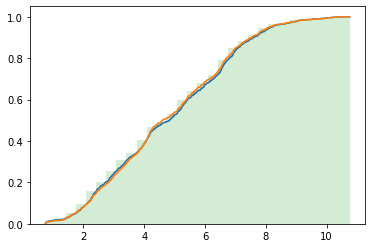

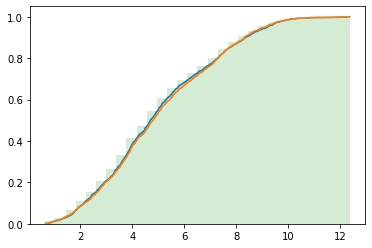

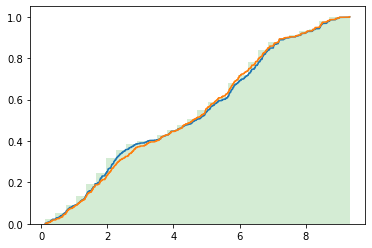

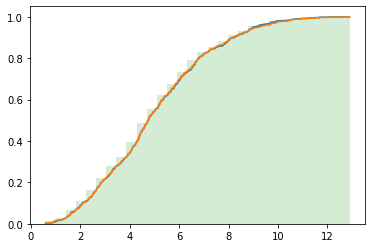

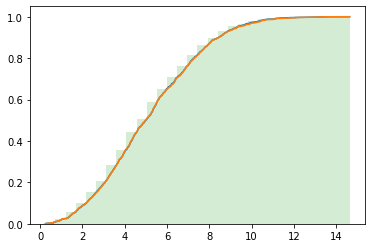

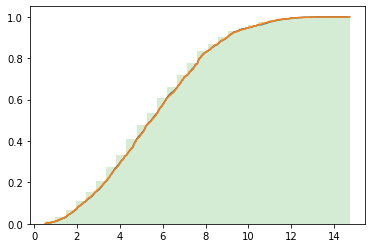

In [42]:
for combo in pairs:
    X2 = np.sort(frag_pair_distance_dict[combo])
    W = frag_weight_dict[combo][np.argsort(frag_pair_distance_dict[combo])]
    N = len(frag_pair_distance_dict[combo])
    F2 = np.array(range(N))/float(N)

    plt.plot(X2, F2)
    plt.plot(X2, np.cumsum(W)/np.sum(W))
    plt.hist(frag_pair_distance_dict[combo], bins=30, alpha=0.2, density=True, cumulative=True)
    plt.show()

100%|██████████| 6/6 [00:00<00:00, 29.53it/s]


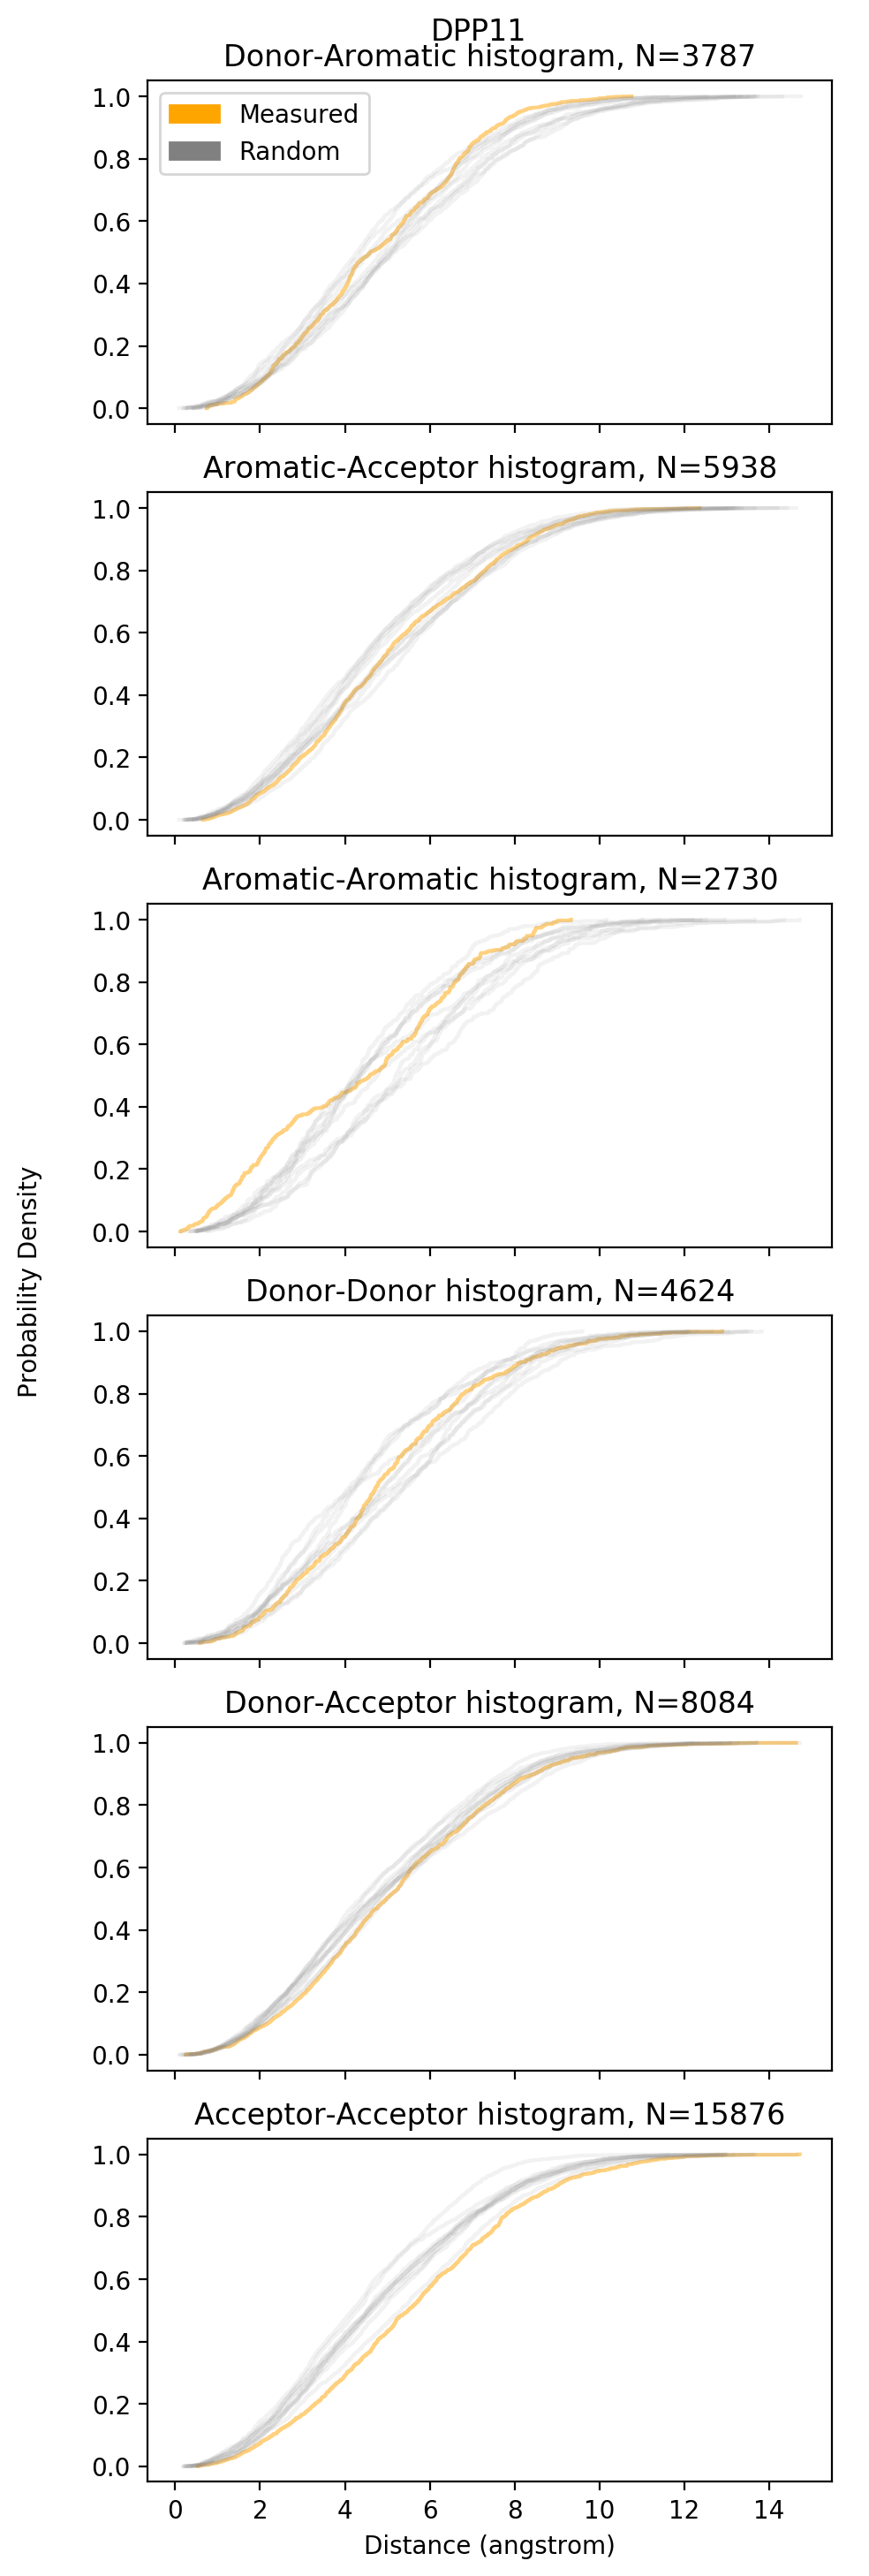

In [19]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(5,18), dpi=200)
fig.suptitle('DPP11', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    X2 = np.sort(frag_pair_distance_dict[combo])
    W = frag_weight_dict[combo][np.argsort(frag_pair_distance_dict[combo])]
    N = len(frag_pair_distance_dict[combo])

    axs[i].set_title('{} histogram, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i].plot(X2, np.cumsum(W)/np.sum(W), alpha=0.5, color='orange')
    
    for n in range(n_rand):
        X2 = np.sort(rand_pair_dicts[n][combo])
        W = rand_weight_dicts[n][combo][np.argsort(rand_pair_dicts[n][combo])]
        N = len(rand_pair_dicts[n][combo])
        axs[i].plot(X2, np.cumsum(W)/np.sum(W), alpha=0.1, color='grey')

legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0].legend(handles=legend_elements, loc='upper left')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()

# P-Value Inspection

KDE uniformly sampled

In [ ]:
combo_list = []

pvals = []
pval_median = []
pval_iqr = []

nx = 500
n_rand = 10
# n_rand = 50


pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

for combo in pairs:
    combo_list.append(combo)
    
    kde_pair = kde_dict_opt[combo]
    print(kde_pair.get_params())
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist # /np.sum(pair_dist)
    
    pval_list = []
    
    rand_dists = []
    for i in range(n_rand):

        kde_rand = rand_kde_dicts[i][combo]
#         print(kde_rand.get_params())
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))

        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist # /np.sum(rand_dist)
    
        rand_dists.append(rand_dist)
        pval_list.append(ks_2samp(pair_dist, rand_dist)[1])
#     pvals.append(pval_list)    
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))


    pvals.append(ks_2samp(pair_dist, np.mean(rand_dists, axis=0))[1])
    
# pval_df = pd.DataFrame(list(zip(combo_list, pvals)), 
#                          columns = ['combo','p-value'])
# print(pval_df.round({'p-value': 4}))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print(pval_df.round({'p-value median': 4, 'p-value iqr': 4}))

# print(list(zip(combo_list, pvals)))

KDE tested on original distribution

In [29]:
combo_list = []

pvals = []
pval_median = []
pval_iqr = []

n_rand = 10
# n_rand = 50

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']

for combo in tqdm(pairs):
    combo_list.append(combo)
    
    kde_pair = kde_dict_opt[combo]
    x = frag_pair_distance_dict[combo]
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    
    pval_list = []
    
    rand_dists = []
    for i in range(n_rand):

        kde_rand = rand_kde_dicts[i][combo]
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))

        rand_dist = rand_dist.flatten()
    
        rand_dists.append(rand_dist)
        pval_list.append(ks_2samp(pair_dist, rand_dist)[1])
    pvals.append(pval_list)    
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))

    # pvals.append(ks_2samp(pair_dist, np.mean(rand_dists, axis=0))[1])
    
# pval_df = pd.DataFrame(list(zip(combo_list, pvals)), 
#                          columns = ['combo','p-value'])
# print(pval_df.round({'p-value': 4}))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print(pval_df)
# print(list(zip(combo_list, pvals)))

100%|██████████| 6/6 [07:03<00:00, 70.60s/it] 

               combo  p-value median   p-value iqr
0     Donor-Aromatic    1.062131e-82  7.678485e-50
1  Aromatic-Acceptor    9.495756e-43  1.643854e-31
2  Aromatic-Aromatic   5.327093e-132  1.615534e-83
3        Donor-Donor    8.405796e-40  6.771282e-28
4     Donor-Acceptor   2.183369e-136  4.946657e-68
5  Acceptor-Acceptor   1.332367e-120  1.662118e-75


In [4]:
pval_median = []
pval_iqr = []
pvals = []

combo_list = []
n_rand = 10

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10
    
# test = ['Acceptor-Acceptor']
for i, combo in tqdm(enumerate(pairs), total=6):
    combo_list.append(combo)
    real = frag_pair_distance_dict[combo]
    n1 = len(real)

    pval_list = []
    for n in range(n_rand):
        rand = rand_pair_dicts[n][combo]

        n2 = len(rand)
        N = rounddown(min(n1,n2))

        # account for length mismatch
        pval_list.append(ks_2samp(np.random.choice(real, N, replace=False), np.random.choice(rand, N, replace=False), mode='exact')[1]) 

    pvals.append(pval_list)
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr)), 
                         columns = ['combo','p-value median', 'p-value iqr'])
print('Unweighted Distributions')
print(pval_df)

for i, combo in enumerate(combo_list):
    print(combo)
    print(np.sort(pvals[i]))

100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


Unweighted Distributions
               combo  p-value median   p-value iqr
0     Donor-Aromatic    4.665549e-08  2.311378e-04
1  Aromatic-Acceptor    9.090841e-12  7.759504e-09
2  Aromatic-Aromatic    3.777782e-40  1.192102e-27
3        Donor-Donor    9.857573e-15  9.414236e-12
4     Donor-Acceptor    4.239289e-20  1.029427e-14
5  Acceptor-Acceptor   4.328561e-102  1.156534e-56
Donor-Aromatic
[7.36464911e-28 3.95321192e-17 1.13923273e-15 5.59733962e-12
 1.55666830e-08 7.77443053e-08 1.30599838e-07 3.08140151e-04
 4.79662776e-03 1.38251224e-02]
Aromatic-Acceptor
[1.45800907e-44 5.04829447e-36 2.43256289e-35 6.14613868e-18
 3.56401417e-14 1.81460414e-11 5.48444418e-09 8.51785684e-09
 3.01133832e-03 1.81313255e-02]
Aromatic-Aromatic
[1.16444453e-55 5.97129114e-53 1.58235106e-49 1.56085505e-48
 5.22619526e-41 7.03294473e-40 2.03996777e-37 1.58946940e-27
 7.55532790e-15 9.76421696e-11]
Donor-Donor
[4.54846342e-44 1.95106666e-28 3.93615756e-28 6.45249741e-18
 8.20525956e-15 1.15098870e-14 2

In [10]:
pval_median = []
pval_iqr = []
pvals = []
n_list = []

combo_list = []
n_rand = 10

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10

# test = ['Acceptor-Acceptor']
for i, combo in tqdm(enumerate(pairs), total=6):
    combo_list.append(combo)
    real = frag_pair_distance_dict[combo]
    W = frag_weight_dict[combo][np.argsort(real)]

    weighted_real = np.cumsum(W)/np.sum(W)
    n1 = len(weighted_real)

    pval_list = []
    for n in range(n_rand):
        rand = rand_pair_dicts[n][combo]
        W = rand_weight_dicts[n][combo][np.argsort(rand)]
        weighted_rand = np.cumsum(W)/np.sum(W)

        n2 = len(weighted_rand)
        N = rounddown(min(n1,n2))

        # account for length mismatch
        pval_list.append(ks_2samp(np.random.choice(weighted_real, N, replace=False), np.random.choice(weighted_rand, N, replace=False), mode='exact')[1]) 
        # pval_list.append(ks_2samp(weighted_real, weighted_rand)[1])

    n_list.append(n1)
    pvals.append(pval_list)
    pval_median.append(np.median(pval_list))
    pval_iqr.append(np.subtract(*np.percentile(pval_list, [75, 25])))

pval_df = pd.DataFrame(list(zip(combo_list, pval_median, pval_iqr, n_list)), 
                         columns = ['combo','p-value median', 'p-value iqr', 'n1'])
print('Weighted Distributions')
print(pval_df)

for i, combo in enumerate(combo_list):
    print(combo)
    print(np.sort(pvals[i]))

100%|██████████| 6/6 [00:00<00:00, 22.52it/s]


Weighted Distributions
               combo  p-value median  p-value iqr     n1
0     Donor-Aromatic        0.636105     0.068301   3787
1  Aromatic-Acceptor        0.414275     0.154837   5938
2  Aromatic-Aromatic        0.102658     0.070395   2730
3        Donor-Donor        0.999429     0.001457   4624
4     Donor-Acceptor        0.998798     0.007138   8084
5  Acceptor-Acceptor        0.978036     0.027714  15876
Donor-Aromatic
[0.41810366 0.57191196 0.61198265 0.62798068 0.635068   0.63714214
 0.66876472 0.68945601 0.7983012  0.84867573]
Aromatic-Acceptor
[0.16322879 0.23741313 0.31043878 0.34207372 0.37693029 0.45162004
 0.46406545 0.4762245  0.64709627 0.73794147]
Aromatic-Aromatic
[0.03778967 0.0457788  0.05917129 0.06774349 0.10134237 0.10397293
 0.13133423 0.13183438 0.18712028 0.29977842]
Donor-Donor
[0.98239462 0.99731261 0.99822628 0.99860462 0.99941512 0.99944211
 0.99964549 0.99982143 0.99984862 0.9999086 ]
Donor-Acceptor
[0.92070145 0.99268106 0.99268198 0.99286245 0.9

# Plots

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


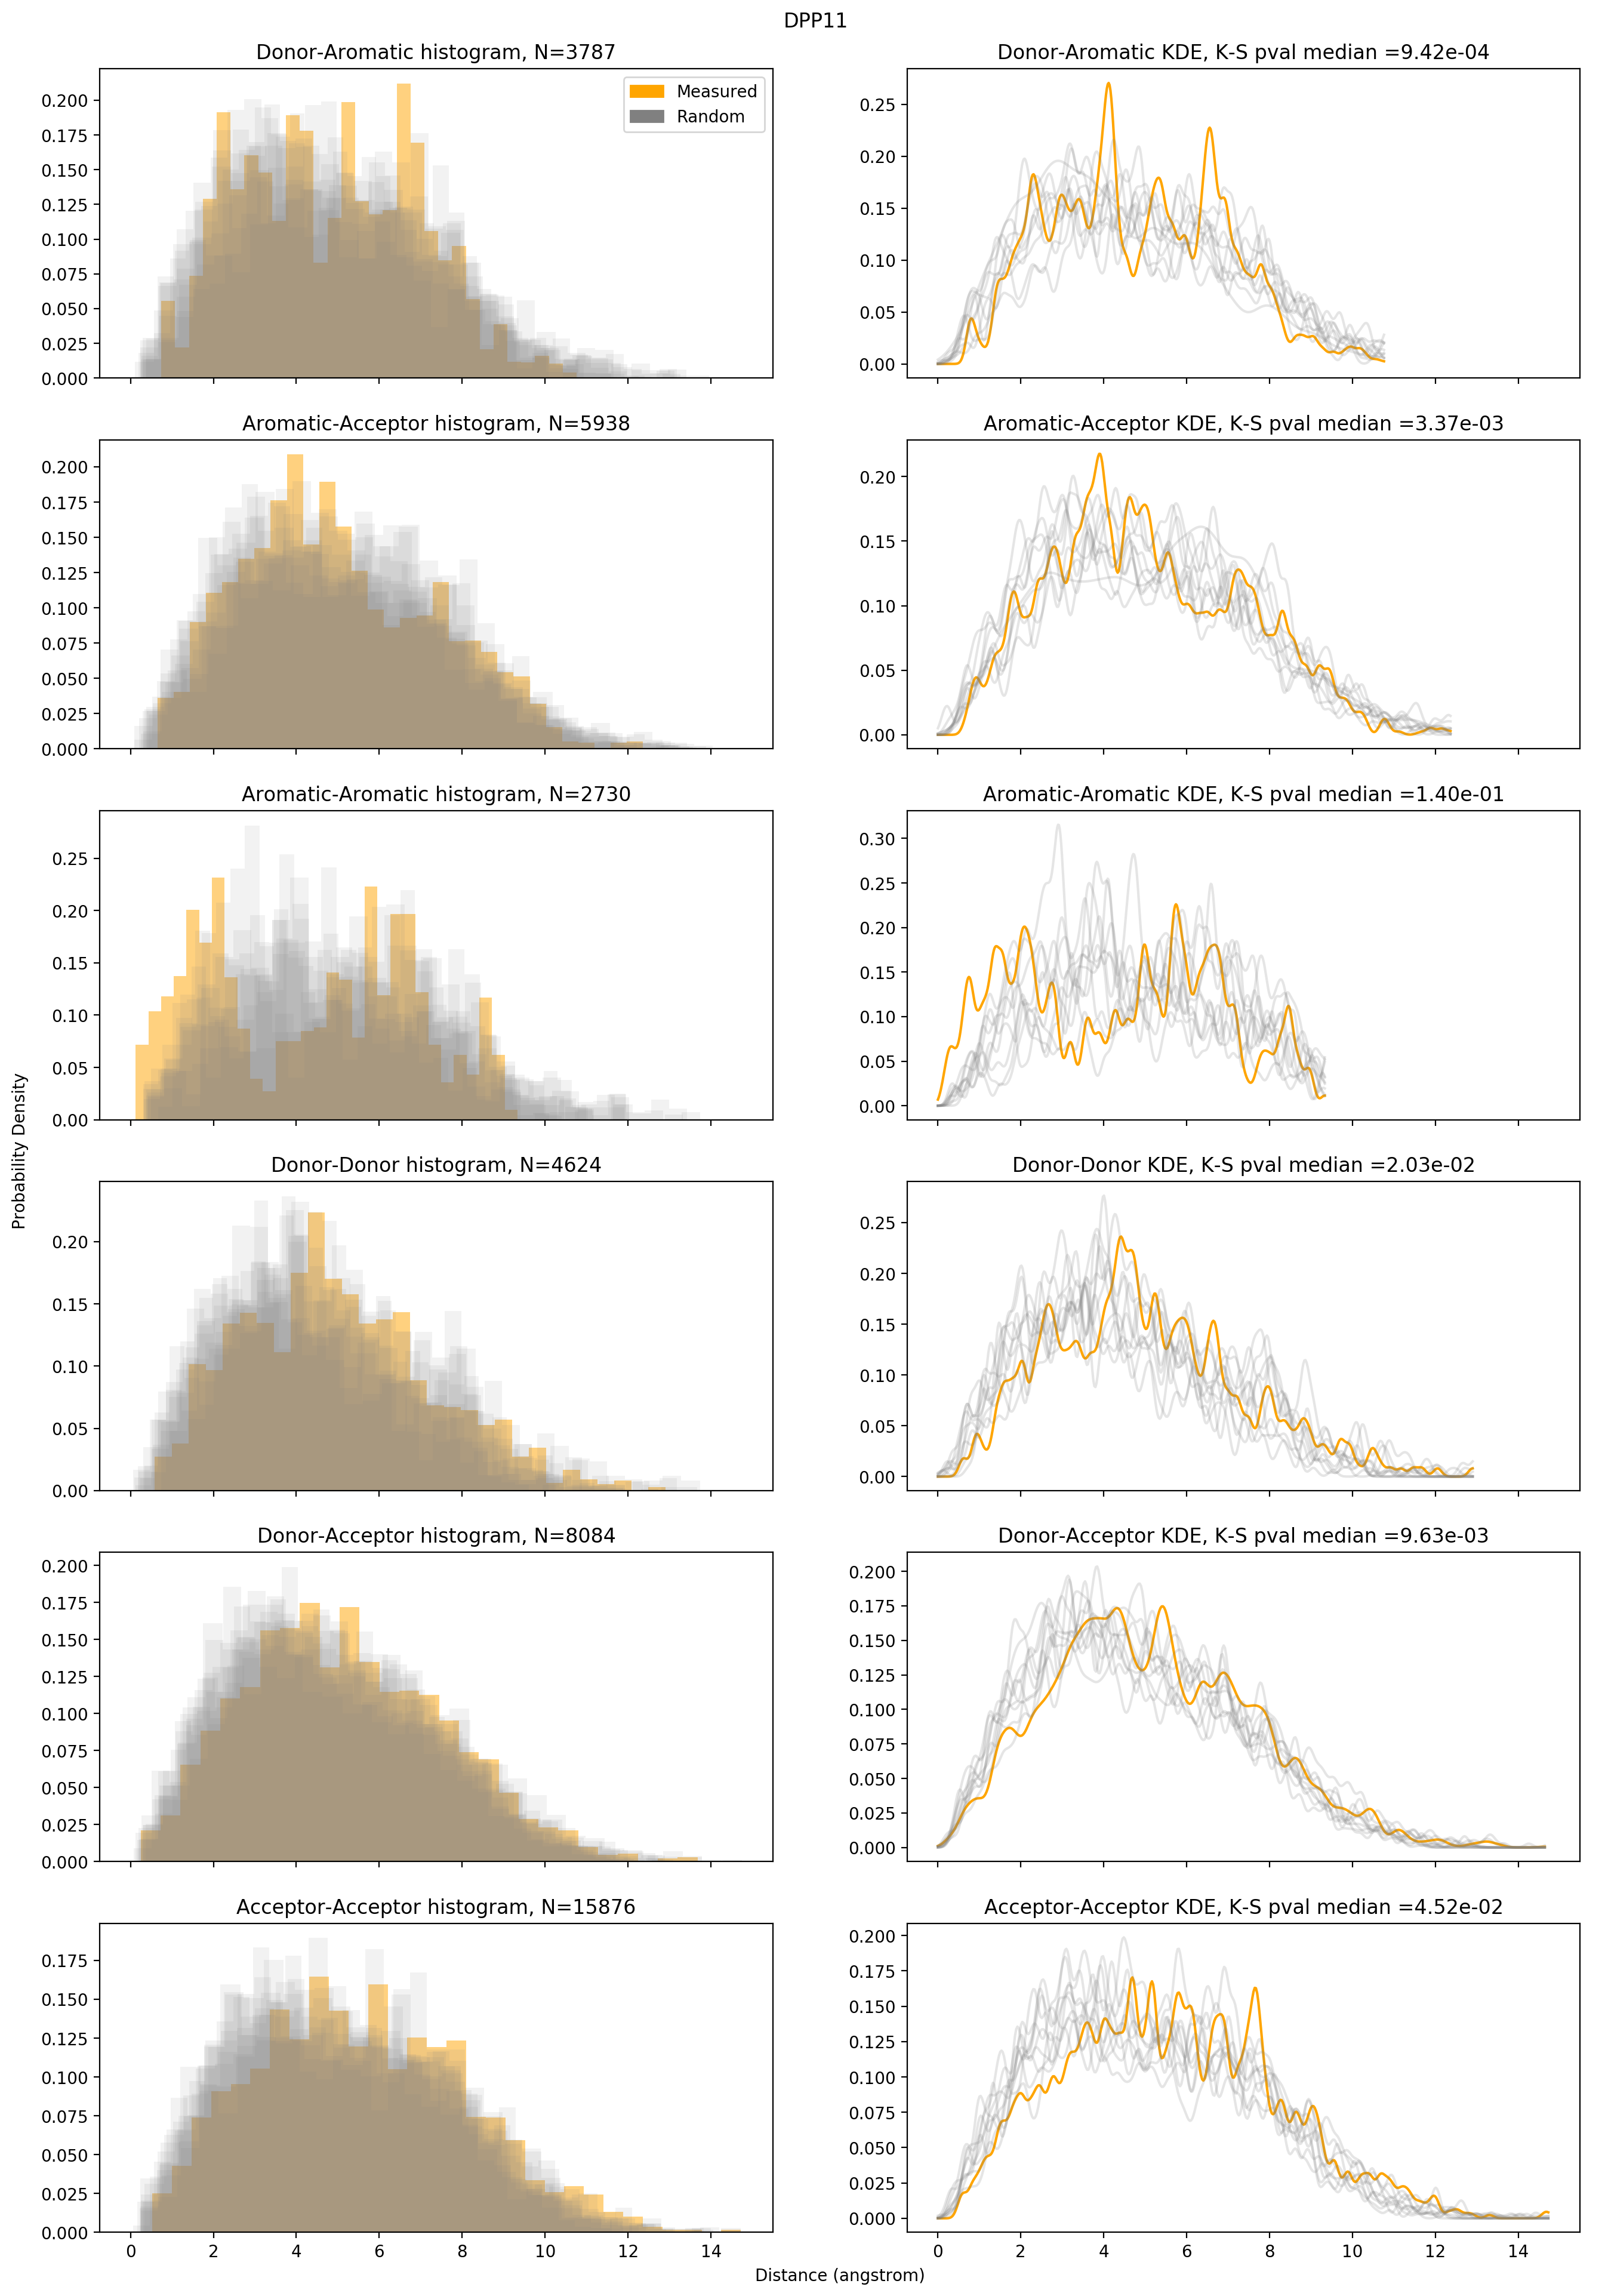

In [9]:
n_bins = 30
n_rand = 10
nx = 500

# mpl.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(16,24), dpi=200)
fig.suptitle('DPP11', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    axs[i,0].set_title('{} histogram, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i,0].hist(frag_pair_distance_dict[combo], bins=n_bins, alpha = 0.5, density=True, color='orange')
    
    axs[i,1].set_title('{} KDE, K-S pval median ={:.2e}'.format(combo, pval_median[i]))
        
    kde_pair = kde_dict_opt[combo]
    
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist#/np.sum(pair_dist)
    
    axs[i,1].plot(x, pair_dist, color='orange')
    
    for n in range(n_rand):
        axs[i,0].hist(rand_pair_dicts[n][combo], bins=30, alpha=0.1, density=True, color='grey')
        
        kde_rand = rand_kde_dicts[n][combo]
    
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))
        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist#/np.sum(rand_dist)
        
        axs[i,1].plot(x, rand_dist, alpha=0.2, color='grey')
        
legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0,0].legend(handles=legend_elements, loc='upper right')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()

100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


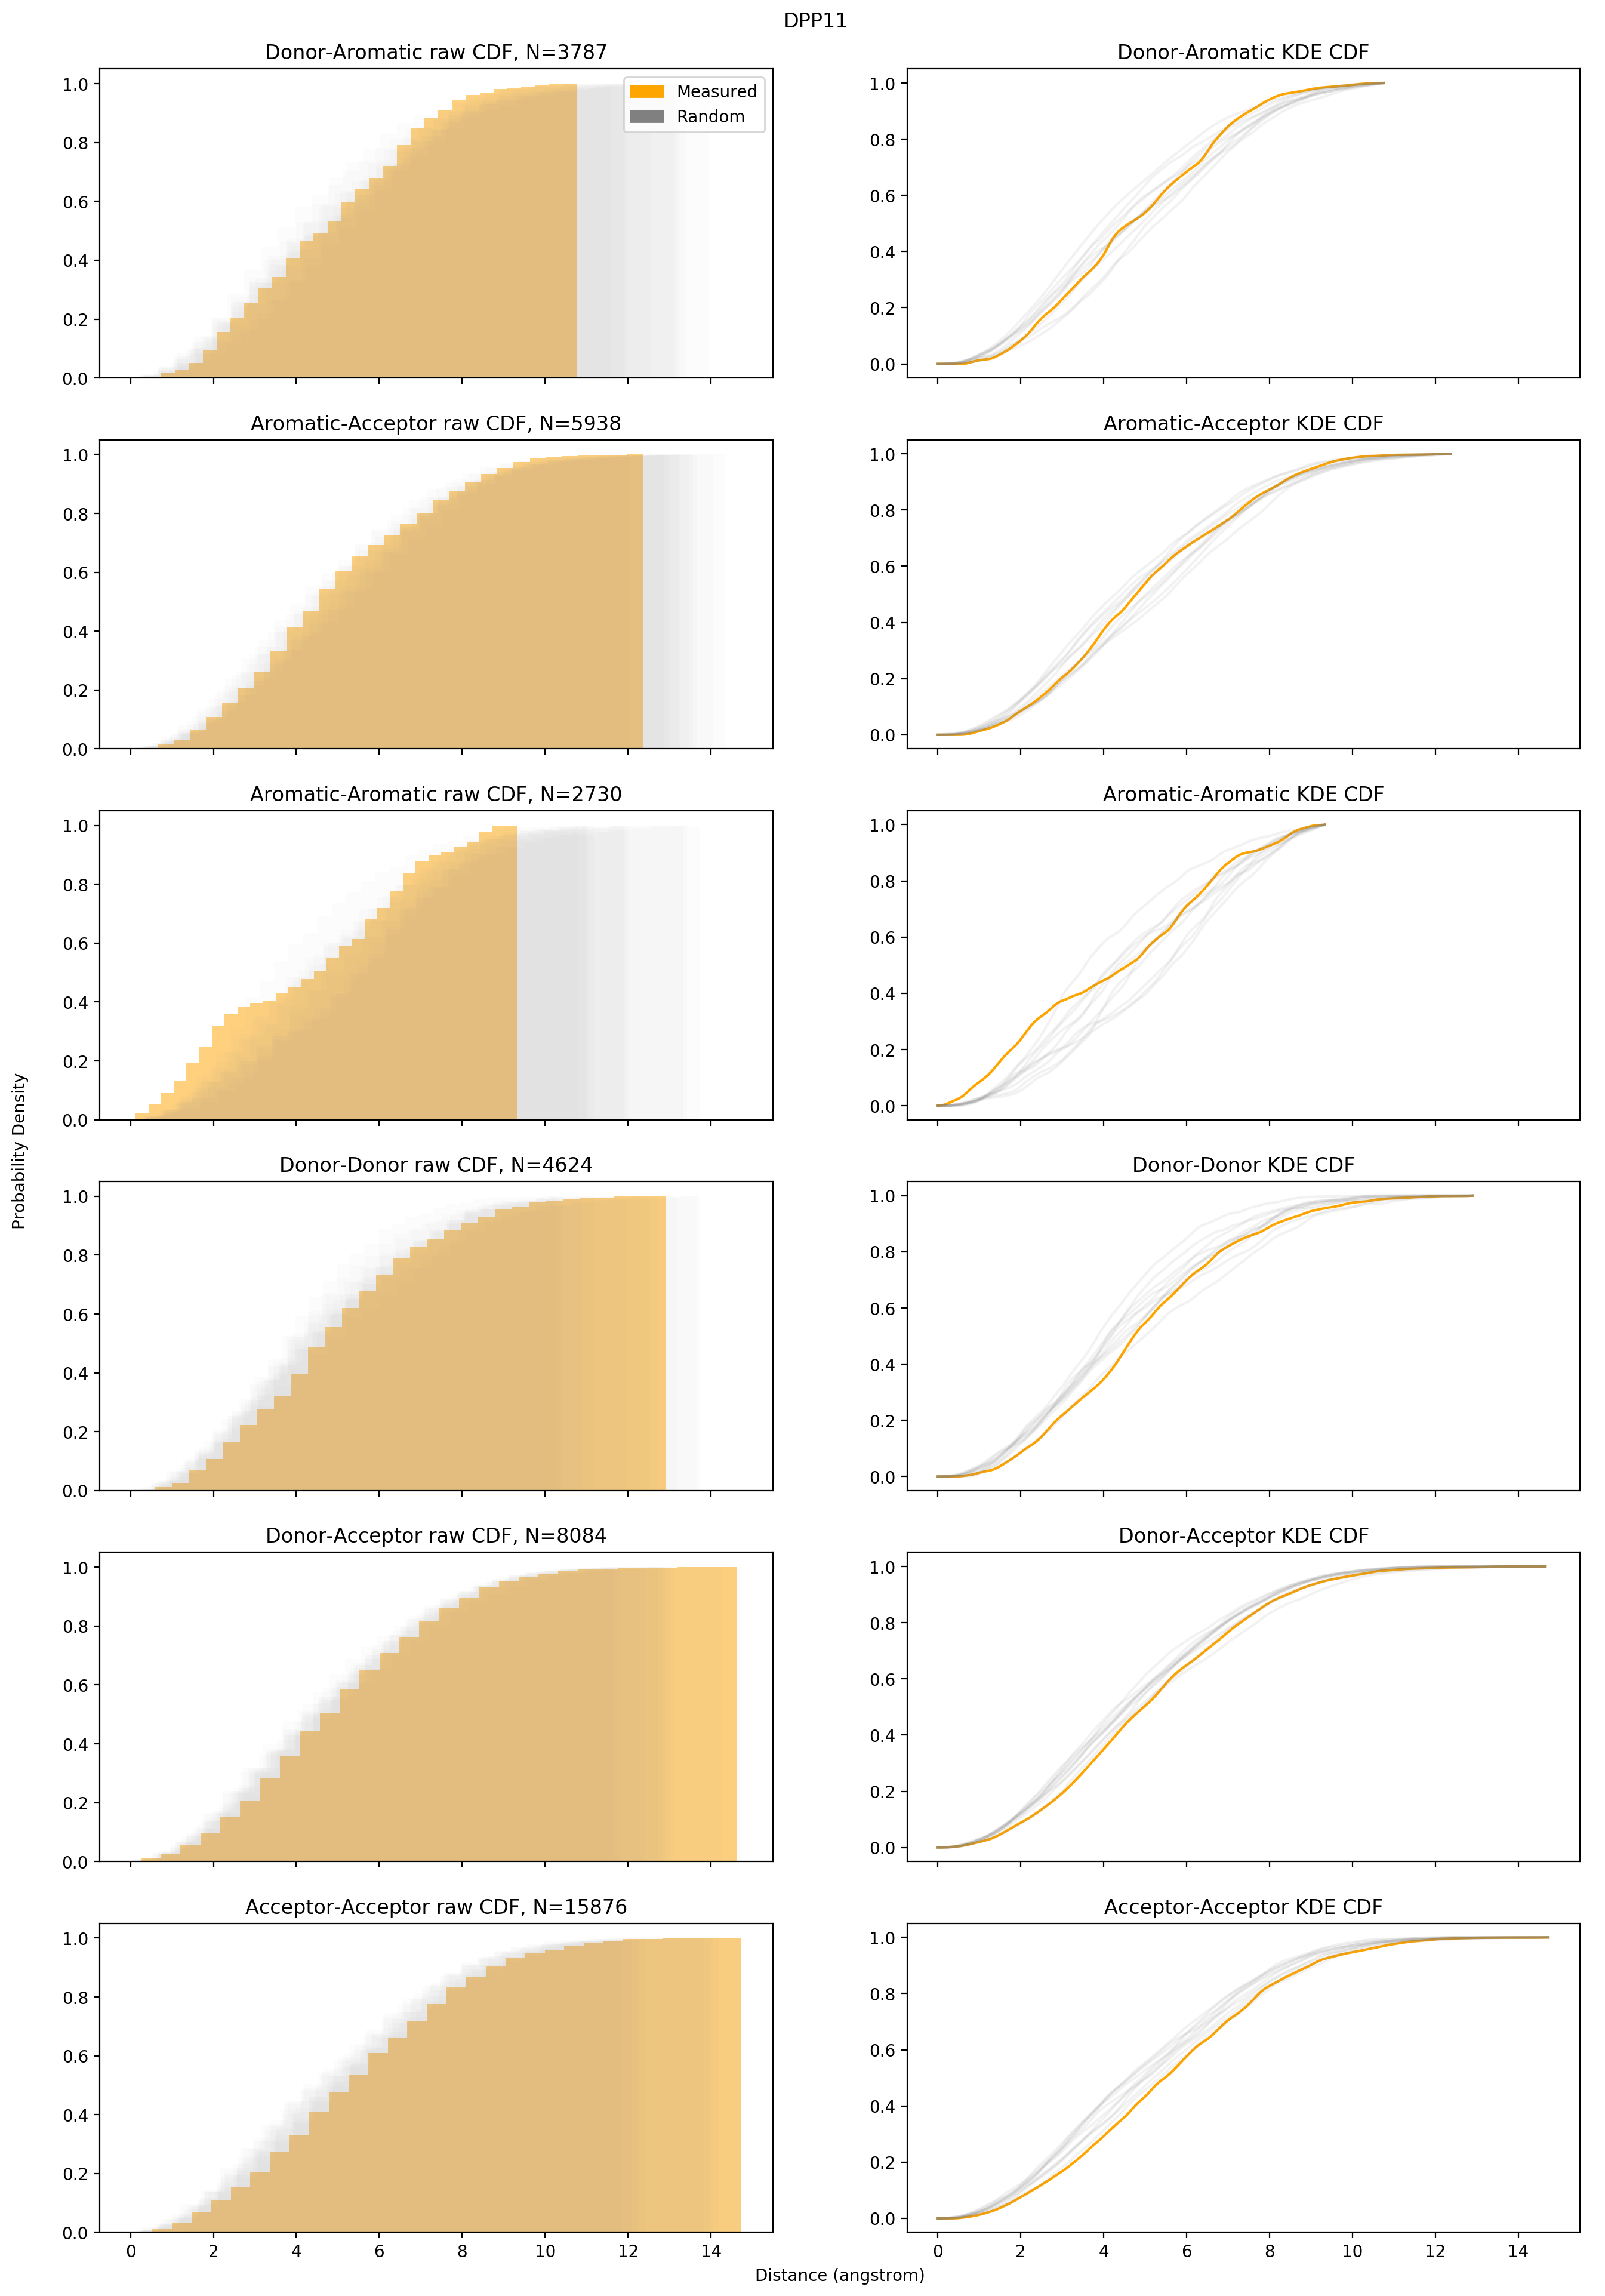

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_bins = 30
n_rand = 10
nx = 500

# mpl.rcParams['figure.dpi'] = 200

fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True, figsize=(16,24), dpi=200)
fig.suptitle('DPP11', y=0.9)

for i, combo in tqdm(enumerate(pairs), total=6):
    axs[i,0].set_title('{} raw CDF, N={}'.format(combo, len(frag_pair_distance_dict[combo])))
    axs[i,0].hist(frag_pair_distance_dict[combo], bins=n_bins, alpha = 0.5, density=True, color='orange', cumulative=True)
    
    axs[i,1].set_title('{} KDE CDF'.format(combo))
        
    kde_pair = kde_dict_opt[combo]
    
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    
    pair_dist = np.exp(kde_pair.score_samples(x.reshape(-1,1)))
    pair_dist = pair_dist.flatten()
    pair_dist = pair_dist#/np.sum(pair_dist)
    
    axs[i,1].plot(x, np.cumsum(pair_dist/np.sum(pair_dist)), color='orange')
    
    for n in range(n_rand):
        axs[i,0].hist(rand_pair_dicts[n][combo], bins=30, alpha=0.02, density=True, color='grey', cumulative=True)
        
        kde_rand = rand_kde_dicts[n][combo]
    
        rand_dist = np.exp(kde_rand.score_samples(x.reshape(-1,1)))
        rand_dist = rand_dist.flatten()
        rand_dist = rand_dist#/np.sum(rand_dist)
        
        axs[i,1].plot(x, np.cumsum(rand_dist/np.sum(rand_dist)), alpha=0.1, color='grey')
        
legend_elements = [Rectangle((0,0), 1,1 , color='orange', label='Measured'),
               Rectangle((0,0), 1,1,  color='grey', label='Random')]
axs[0,0].legend(handles=legend_elements, loc='upper right')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density', labelpad=20)
fig.show()